In the respository Analyzing-calcium-imaging-in-MATLAB we isolated the $\frac{\Delta F}{F}$ traces of individual neurons from calcium imaging videos, and then identified the peaks and troughs of calcium transients in the $\frac{\Delta F}{F}$ trace. These $\frac{\Delta F}{F}$ traces were obtained from neurons in the hippocampus, a region of the brain that is associated with forming spatial memories. As a result, the activity of these neurons is highly correlated to the mouse's position as it moves. We can use this trait to perform a lot of cool tasks, including training algorithms to predict the mouse's position from periods of activity the decoder has never seen before. 

In this notebook we will use previously identified calcium transients to train a bayesian decoder to predict a mouse's position along a linear track. To start we need to convert the data from a '.mat' file to something that's readable in Python. I have already converted the relevant data to an easier to use form using the function genHMMcode.m. I have made a copy of this data in the data folder and called it hmmtest_c27_2NRE.mat. To start we will read in the data and convert it to a form that's easier to use in Python

In [26]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import scipy.ndimage.filters
import os
import sys
import warnings
import numpy as np
import time
import random
import seaborn as sns
import scipy.stats as stats
import h5py


#Read data in from MATLAB. Needs to be saved with option 'v7.3' to be correctly read in
notebook_path = os.getcwd()
matPath = notebook_path + "\data\exampledata_c27_2NRE.mat"
f = h5py.File( matPath, 'r')
trandat = f['hmmtestspikesmooth']
timeDat =  f['microscopeTime']
posDat = f['microscopeLocation']
troughDat = np.array(trandat[()])
mTime = timeDat[()]
mTime = mTime[0]
mPos = posDat[()]
mPos = mPos[0]*(300/270)
f.close()


<IPython.core.display.Javascript object>


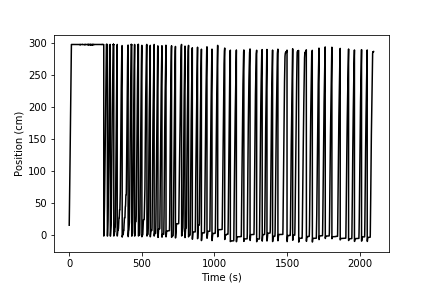

Text(0, 0.5, 'Position (cm)')

In [117]:
plt.figure(0)
plt.plot(mTime, mPos, c = 'k')
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')

From this plot we can see that the track is 300 cm long, and that the mouse's position is reset at the start of every lap. For the first lap the mouse took a while to complete the behavior, and as a result its position is stuck at 300 cm. Also, the mouse likes to start laps, and then pause for a couple seconds about 30 cm into the track. Since we can't force an animal to perform perfectly we need to accpet that real-world data will sometimes have imperfections like this. Now that we've imported the data and have some idea about what the mouse was doing we can start analyzing what individual neurons are doing in the brain. First we convert the binary vector troughDat to just the indexes where a calcium transient occurred. 

<IPython.core.display.Javascript object>


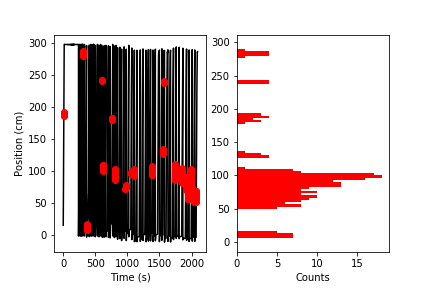

Text(0.5, 0, 'Counts')

In [116]:
cind = np.arange(0, np.size(fulldat, 0))
slist = [[] for _ in np.arange(0,np.size(troughDat, 0))]
for cell in cind:
    slist[cell] = list(np.array(np.where(troughDat[cell, :] == 1))[0])

#Visualize the data from a single neuron so we can see where it's active along the track
mbins = np.arange(0, 270, 3)*(300/270)
plt.figure(1)
plt.subplot(121)
plt.plot(mTime, mPos, c = 'k', zorder = 1)
plt.scatter(mTime[slist[30]], mPos[slist[30]], c = 'r', zorder = 2)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.subplot(122)
plt.hist(mPos[slist[30]], bins = mbins, orientation=u'horizontal', color = 'r')
plt.xlabel('Counts')

These plots are our first evidence that the neurons we're recording from are indeed correlated to the mouse's position along the linear track. We can see from the left subplot that the neuron tends to be active around 100 cm into the track. This is recapitulated in the right histogram.

Next, let's make an image of the composite activity of all neurons we recoded from.

<IPython.core.display.Javascript object>


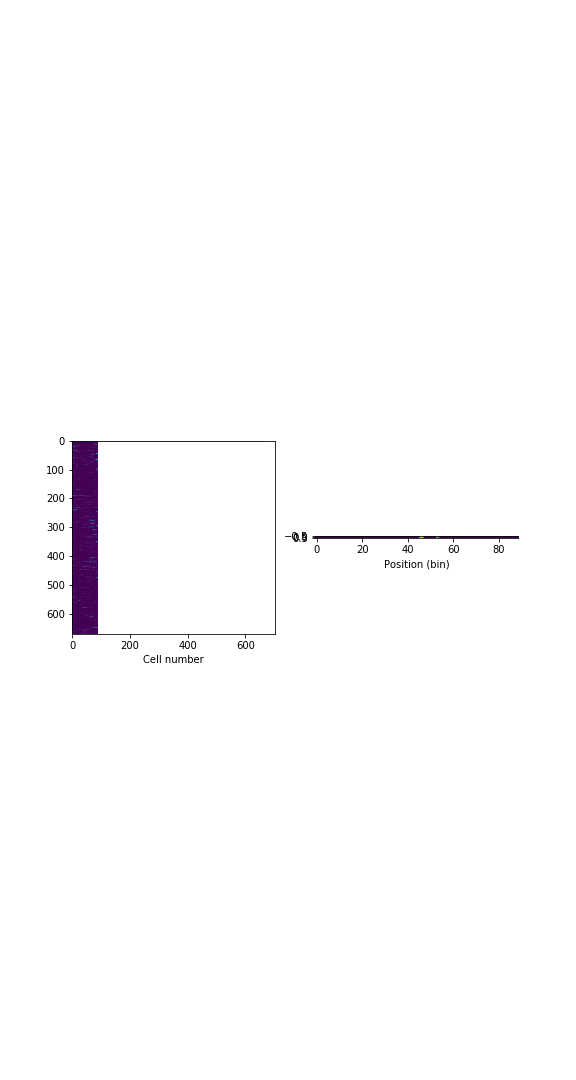

Text(0.5, 0, 'Position (bin)')

In [125]:
#Initialize matrices for the image and populate with the values for each neuron
nImage = np.zeros([np.size(slist), np.size(bins)-1])
mInd = np.zeros([1, np.size(slist)])
for cell in np.arange(0, np.size(slist)):
    histcounts = np.histogram(mPos[slist[cell]], bins)
    mInd[0, cell] = np.argwhere(histcounts[0] == np.max(histcounts[0])).astype(int)[0]
    nImage[cell, :] = histcounts[0]
#Visualize the unsorted, and sorted spatial profiles
plt.figure(2,figsize=(8, 15))
plt.subplot(121)
plt.imshow(nImage)
plt.xlabel('Position (bin)')
plt.subplot(122)
plt.imshow(nImage[np.argsort(mInd[0]), :])
plt.xlabel('Position (bin)')

On the left we have the spatial activity profiles of all neurons sorted arbitrarily by when they were identified with constrained non-negative matrix factorization. On the right we have the profiles sorted by the location along the track where there is maximum calcium actvity. As we can see there are a large number of neurons that are tuned to the mouse's position along the track. We can take advantage of this spatial tuning to train a bayesian decoder. Our decoder will estimate $\hat{y}$ with:
$$\hat{y} = \underset{y}{\mathrm{argmax}}\prod_{i=1}^{N} \frac{p(x_{it}|y)p(y)}{p(x)}$$
Where N is the number of neurons, y the position along the track, and xit is a vector that is 1 on frame t when the neuron is active and 0 when it is not. This vector has already been calculated in the variable troughDat. From the data we can calculate p(x|y) and p(x) from a set of training laps. Because spatially tuned neurons are most active when the mouse is moving we will restrict our decoder to run only on laps where the mouse is running faster than 2 cm/s. 

<IPython.core.display.Javascript object>


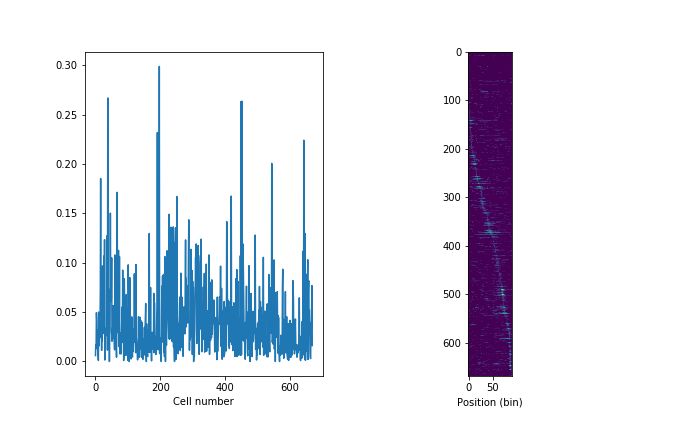

Text(0.5, 0, 'Position (bin)')

In [234]:
#Identify when new laps start with diff. Only new laps will have large negative values
mPosDiff = np.diff(mPos)
lapInd = np.argwhere(mPosDiff < -20)
lapstart = np.append(1, lapInd)
lapend = np.append(lapInd, np.size(mPos))
#Data is collected at 20 Hz, so we se the threahold to take into account the acquisition rate 
highrun = np.argwhere(mPosDiff > 2*0.05)

#Generate a list of lists for each lap that contains the indexes where the mouse was running faster than 2cm/s for that lap.
highrunlap = [[] for _ in np.arange(0,np.size(lapstart, 0))]
for lap in np.arange(0, np.size(lapstart)):
    lapind = np.arange(lapstart[lap], lapend[lap])
    run = [value for value in lapind if value in highrun]
    highrunlap[lap] = run
     
#Select 1/3 of the laps to use as training laps for our decoder and generate p(x|y) and p(x) from these laps
nLaps = np.round(np.size(lapstart)*1/3).astype(int)
samplevec = np.arange(0, np.size(lapstart)).astype(int).tolist()
trainLaps = np.sort(random.sample(samplevec, nLaps))
testlaps = [value for value in samplevec if value not in trainLaps]


trainInd = np.empty([0, 1])
for lap in trainLaps:
    trainInd = np.append(trainInd, highrunlap[lap])
    
trainInd = trainInd.astype(int)    
plt.figure(3)

Pxy = np.zeros([np.size(slist), np.size(bins)-1])
mIndtrain = np.zeros([np.size(slist)])
positioncounts = np.histogram(mPos[trainInd], bins)
px = np.zeros([np.size(slist)])

for cell in np.arange(0, np.size(slist)):
    useAct = []
    useAct = [value.astype(int) for value in slist[cell] if value in trainInd]
    px[cell] = len(slist[cell])/len(trainInd)
    histcountsneuron = np.histogram(mPos[useAct], bins)
    normcounts = histcountsneuron[0]/positioncounts[0]
    mIndtrain[cell] = np.argwhere(histcountsneuron[0] == np.max(histcountsneuron[0])).astype(int)[0]
    Pxy[cell, :] = normcounts

plt.figure(3,figsize=(8, 15))
plt.subplot(121)
plt.plot(px)
plt.xlabel('Cell number')
plt.subplot(122)
plt.imshow(Pxy[np.argsort(mIndtrain), :])
plt.xlabel('Position (bin)')

<IPython.core.display.Javascript object>


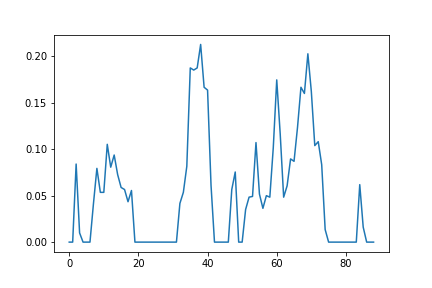